Import Library

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#tensorflow 관련 Library
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras

import matplotlib.pyplot as plt
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


Kaggle에서 데이터 가져오기

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subirbiswas19/skin-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 17.3M/17.3M [00:02<00:00, 8.69MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1


Data set 전처리 및 생성

In [ ]:
img_size = (244,244)

# 이미지 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,         # 정규화 (0~1 범위)
    rotation_range=30,      # 랜덤 회전 (최대 30도)
    width_shift_range=0.2,  # 좌우 이동 (이미지 너비의 20%)
    height_shift_range=0.2, # 상하 이동 (이미지 높이의 20%)
    shear_range=0.2,        # 전단 변형 (Shear)
    zoom_range=0.2,         # 랜덤 줌 (최대 20%)
    horizontal_flip=True,   # 좌우 반전
    fill_mode='nearest',    # 빈 픽셀을 보완하는 방식 (nearest, constant, reflect 등)
    validation_split=0.2    # 검증 데이터 분리 (20%)
)

train_path = path + "/skin-disease-datasaet/train_set"
test_path = path + "/skin-disease-datasaet/test_set"

# 학습 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= True,
    class_mode='categorical',
    subset="training"
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 검증 데이터 로드
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= False,
    class_mode='categorical',
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 로드
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= False,
    class_mode='categorical'
)

print(np.bincount(train_generator.classes))
print(np.bincount(val_generator.classes))

Found 741 images belonging to 8 classes.
Found 183 images belonging to 8 classes.
Found 233 images belonging to 8 classes.
[108  64 100 104  72  80 109 104]
[27 16 24 25 18 20 27 26]


In [ ]:
n_channels = train_generator.image_shape[-1]
classes = train_generator.class_indices
n_classes = train_generator.num_classes

n_train = train_generator.samples
n_val = val_generator.samples

print(n_train, n_val)

741 183


Show a Sample Data

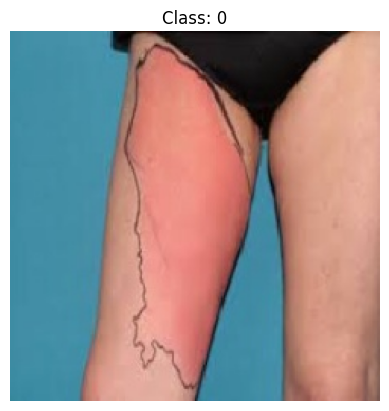

In [ ]:
# 배치에서 랜덤하게 이미지 하나 가져오기
batch_images, batch_labels = next(train_generator)  # 배치 가져오기
idx = np.random.randint(batch_images.shape[0])  # 배치 내 랜덤 인덱스 선택

# 선택한 이미지 및 라벨 출력
plt.imshow(batch_images[idx])
plt.title(f"Class: {np.argmax(batch_labels[idx])}")  # One-Hot Encoding -> 정수 라벨 변환
plt.axis("off")
plt.show()

Building Input Data Pipelines

In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = train_generator.image_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base
def build_transfer_learning_model(num_classes):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


<ipython-input-6-beb51d516a45>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = train_generator.image_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Training the Model

In [ ]:
# Build the transfer learning model
transfer_learning_model = build_transfer_learning_model(n_classes)

# Learning rate schedule callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early Stopping callback (과적합 방지)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history_transfer_learning = transfer_learning_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate on the test set
test_loss, test_accuracy = transfer_learning_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4415 - loss: 1.7010 - val_accuracy: 0.8251 - val_loss: 0.4569 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8762 - loss: 0.4310 - val_accuracy: 0.8907 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9364 - loss: 0.2102 - val_accuracy: 0.8634 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9646 - loss: 0.1350 - val_accuracy: 0.8907 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9602 - loss: 0.1265 - val_accuracy: 0.9016 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9778 - loss: 0.0837 - val_accuracy: 0.8852 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9885 - loss: 0.0676 - val_accuracy: 0.907

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pred2 = transfer_learning_model.predict(test_generator)
y_pred = np.argmax(pred2, axis=1)
y_true = test_generator.labels
print(classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.1f}%".format(accuracy))

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.83      0.95      0.88        20
           2       1.00      0.84      0.92        32
           3       0.97      0.97      0.97        33
           4       0.91      0.87      0.89        23
           5       0.92      0.92      0.92        25
           6       1.00      0.94      0.97        34
           7       0.84      0.97      0.90        33

    accuracy                           0.93       233
   macro avg       0.93      0.93      0.93       233
weighted avg       0.94      0.93      0.93       233

Accuracy of the Model: 93.1%


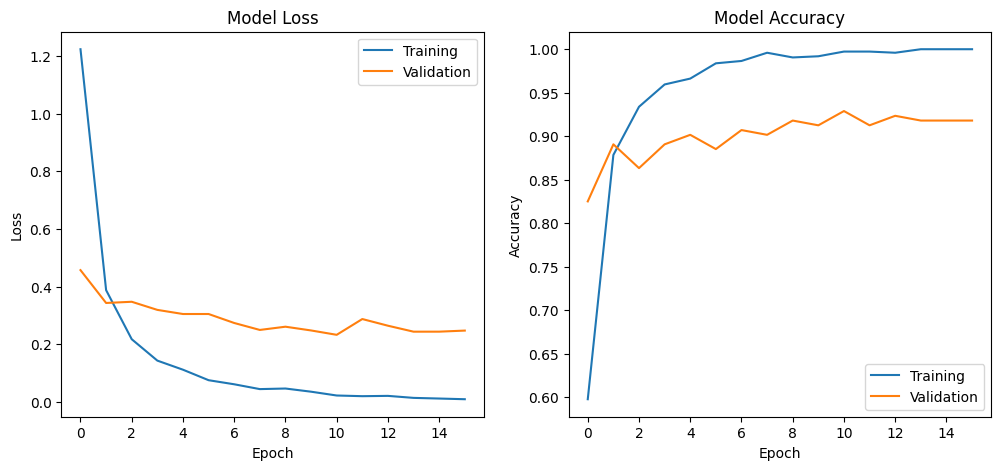

In [ ]:
# 손실 (Loss) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

# 정확도 (Accuracy) 그래프
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

In [ ]:
transfer_learning_model.save("my_model.keras")